# Prepare the Models
We load or compute the time evolution for several models:
- **Surrogate model**: extracted from NRSur7dq2, providing accurate waveform data.
- **2.5PN**: post-Newtonian model with 2PN conservative dynamics and 2.5PN radiation-reaction terms (https://arxiv.org/pdf/gr-qc/9804079)
- **3PN**: conservative dynamics at 3PN order, integrated with radiation reaction at 3.5PN order.(https://arxiv.org/pdf/1204.1043)
- **3.5PN**: radiation reaction averaged model at 3.5PN.(https://arxiv.org/pdf/1204.1043)
- **PINN**: Physics-Informed Neural Network prediction trained on a waveform dataset.


# POST-NEWTONIAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# ------------------------
# System Parameters
# ------------------------
q = 1.5
m2 = 1.0
m1 = q * m2
m = m1 + m2
nu = m1 * m2 / m**2

## 2PN

### Evolving \( dv/dt \) — Full 2.5PN Dynamics with 2PN Conservative Corrections

In this model, we evolve the full Cartesian dynamics $(x(t), y(t))$ of a binary system including:
- Conservative corrections up to **2PN** order in the orbital frequency $\omega^2$,
- Radiation reaction at **2.5PN** order through a damping force.

The state vector is:
$$
y = (x, y, v_x, v_y, \phi)
$$
where $(x, y)$ are Cartesian positions, $(v_x, v_y)$ are velocities, and $\phi$ is the orbital phase.

The system of differential equations is:

$$
\frac{dx}{dt} = v_x, \quad \frac{dy}{dt} = v_y
$$

$$
\frac{dv_x}{dt} = -\omega^2 x - \mathcal{F}_d v_x, \quad \frac{dv_y}{dt} = -\omega^2 y - \mathcal{F}_d v_y
$$

$$
\frac{d\phi}{dt} = \omega_{\text{inst}}, \quad \text{where} \quad \omega_{\text{inst}} = \frac{x v_y - y v_x}{r^2}
$$

Here:
- The orbital frequency $\omega^2$ includes 2PN conservative corrections:
$$
\omega^2 = \frac{M}{r^3} \left( 1 + (-3 + \nu) \gamma + \left(6 + \frac{41}{4} \nu + \nu^2\right) \gamma^2 \right)
$$
with $\gamma = \frac{M}{r}$.

- The damping force $\mathcal{F}_d$ models gravitational-wave radiation at 2.5PN order:
$$
\mathcal{F}_d = \frac{32}{5} \frac{M^3 \nu}{r^4}
$$

These expressions correspond to the 2PN-accurate conservative equations plus the 2.5PN radiation-reaction terms derived in Equations (8.5) and (8.6) of Blanchet et al., [arXiv:gr-qc/9804079](https://arxiv.org/pdf/gr-qc/9804079).



In [2]:
# ------------------------
# Choose PN Order
# ------------------------
omega_order = "2PN"     # Options: "2PN" or "3PN"
damping_order = "2.5PN" # Options: "2.5PN" or "3.5PN"

# ------------------------
# PN Expressions
# ------------------------
def omega_sq_pn(r, m, nu, order="2PN"):
    gamma = m / r
    if order == "2PN":
        return (m / r**3) * (
            1 + (-3 + nu) * gamma + (6 + (41/4) * nu + nu**2) * gamma**2
        )
    elif order == "3PN":
        gamma2 = gamma**2
        gamma3 = gamma**3
        term1 = -3 + nu
        term2 = 6 + (41/4) * nu + nu**2
        term3 = (
            -10 + (-75707/840 + (41 * np.pi**2) / 64) * nu
            + (19/2) * nu**2 + nu**3
        )
        return (m / r**3) * (1 + gamma * term1 + gamma2 * term2 + gamma3 * term3)
    else:
        raise ValueError("omega_sq_pn: order must be '2PN' or '3PN'")

def damping_force(r, m, nu, order="2.5PN"):
    if order == "2.5PN":
        return (32/5) * (m**3 * nu) / r**4
    elif order == "3.5PN":
        gamma = m / r
        return (32/5) * (m**3 * nu) / r**4 * (
            1 + gamma * (-743/336 - (11/4) * nu)
        )
    else:
        raise ValueError("damping_force: order must be '2.5PN' or '3.5PN'")

# ------------------------
# Initial Conditions
# ------------------------
r0 = 15.8
omega0 = np.sqrt(omega_sq_pn(r0, m, nu, omega_order))
v0 = r0 * omega0
y0 = np.array([r0, 0.0, 0.0, v0, 0.0])  # [x, y, vx, vy, phi]

# ------------------------
# PN Dynamics
# ------------------------
def relative_dynamics(t, y, m, nu, omega_order="2PN", damping_order="2.5PN"):
    x, y_, vx, vy, phi = y
    r_vec = np.array([x, y_])
    v_vec = np.array([vx, vy])
    r = np.linalg.norm(r_vec)

    omega_sq = omega_sq_pn(r, m, nu, omega_order)
    damping = damping_force(r, m, nu, damping_order)

    dxdt = vx
    dydt = vy
    dvxdt = -omega_sq * x - damping * vx
    dvydt = -omega_sq * y_ - damping * vy
    # omega_inst = (x * vy - y_ * vx) / r**2
    dphidt = np.sqrt(omega_sq)
    # dphidt = omega_inst

    return np.array([dxdt, dydt, dvxdt, dvydt, dphidt])

# ------------------------
# RK4 Integrator
# ------------------------
def rk4_step(f, y, t, dt, *args):
    k1 = f(t, y, *args)
    k2 = f(t + dt/2, y + dt/2 * k1, *args)
    k3 = f(t + dt/2, y + dt/2 * k2, *args)
    k4 = f(t + dt, y + dt * k3, *args)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# ------------------------
# Time Integration
# ------------------------
t = 0.0
dt = 0.1
T_final = 10000
y = y0.copy()

times_2PN = []
results_2PN = []

while t < T_final and np.linalg.norm(y[0:2]) > 0.5:
    times_2PN.append(t)
    results_2PN.append(y.copy())
    y = rk4_step(relative_dynamics, y, t, dt, m, nu, omega_order, damping_order)
    t += dt

results_2PN = np.array(results_2PN)
times_2PN = np.array(times_2PN)


### Plot r(t)

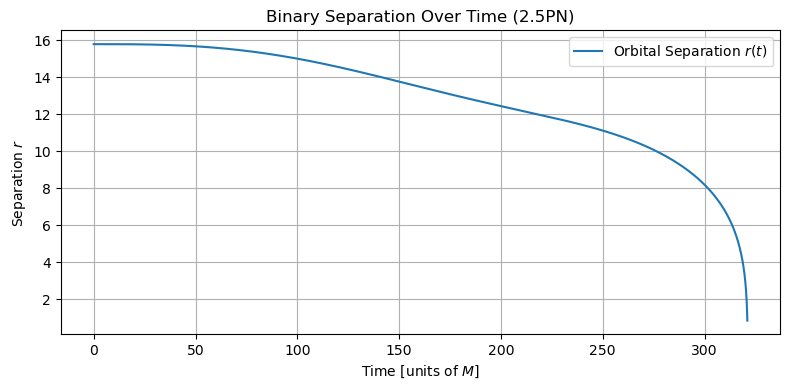

In [3]:
# r(t) is just the norm of the position vector (x, y)
r_vals_2PN = np.linalg.norm(results_2PN[:, 0:2], axis=1)

# Plot r(t)
plt.figure(figsize=(8, 4))
plt.plot(times_2PN, r_vals_2PN, label='Orbital Separation $r(t)$')
plt.xlabel('Time [units of $M$]')
plt.ylabel('Separation $r$')
plt.title(f'Binary Separation Over Time ({damping_order})')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 3.5 PN

### Evolving \( dv/dt \) — Full 3PN Dynamics with 3.5PN Radiation Reaction

In this model, we evolve the full Cartesian dynamics $(x(t), y(t))$ of a binary system, including:
- Conservative corrections up to **3PN** order in the orbital frequency $\omega^2$,
- Radiation reaction corrections up to **3.5PN** order through a damping force.

The state vector is:
$$
y = (x, y, v_x, v_y, \phi)
$$
where $(x, y)$ are Cartesian positions, $(v_x, v_y)$ are velocities, and $\phi$ is the orbital phase.

The system of differential equations is:

$$
\frac{dx}{dt} = v_x, \quad \frac{dy}{dt} = v_y
$$

$$
\frac{dv_x}{dt} = -\omega^2 x - \mathcal{F}_d v_x, \quad \frac{dv_y}{dt} = -\omega^2 y - \mathcal{F}_d v_y
$$

$$
\frac{d\phi}{dt} = \omega_{\text{inst}}, \quad \text{where} \quad \omega_{\text{inst}} = \frac{x v_y - y v_x}{r^2}
$$

Here:
- The orbital frequency $\omega^2$ includes 3PN conservative corrections:
$$
\omega^2 = \frac{M}{r^3} \left( 1 + (-3 + \nu) \gamma + \left(6 + \frac{41}{4}\nu + \nu^2\right) \gamma^2 + \left(-10 + \left(-\frac{75707}{840} + \frac{41 \pi^2}{64}\right)\nu + \frac{19}{2}\nu^2 + \nu^3\right) \gamma^3 \right)
$$
with $\gamma = \frac{M}{r}$.

- The damping force $\mathcal{F}_d$ includes 3.5PN radiation-reaction terms:
$$
\mathcal{F}_d = \frac{32}{5} \frac{M^3 \nu}{r^4} \left( 1 + \gamma \left( -\frac{743}{336} - \frac{11}{4} \nu \right) \right)
$$

These corrections model the conservative dynamics and gravitational-wave energy loss accurately up to 3.5PN order, assuming a quasi-circular inspiral.These expressions correspond to the 3PN-accurate conservative equations plus the 3.5PN radiation-reaction terms derived in Equations (2.4) and (2.9) of Blanchet et al., [arXiv:gr-qc/9804079](https://arxiv.org/pdf/1204.1043).




In [4]:
# ------------------------
# Choose PN Order
# ------------------------
omega_order = "3PN"     # Options: "2PN" or "3PN"
damping_order = "3.5PN" # Options: "2.5PN" or "3.5PN"

# ------------------------
# PN Expressions
# ------------------------
def omega_sq_pn(r, m, nu, order="2PN"):
    gamma = m / r
    if order == "2PN":
        return (m / r**3) * (
            1 + (-3 + nu) * gamma + (6 + (41/4) * nu + nu**2) * gamma**2
        )
    elif order == "3PN":
        gamma2 = gamma**2
        gamma3 = gamma**3
        term1 = -3 + nu
        term2 = 6 + (41/4) * nu + nu**2
        term3 = (
            -10 + (-75707/840 + (41 * np.pi**2) / 64) * nu
            + (19/2) * nu**2 + nu**3
        )
        return (m / r**3) * (1 + gamma * term1 + gamma2 * term2 + gamma3 * term3)
    else:
        raise ValueError("omega_sq_pn: order must be '2PN' or '3PN'")

def damping_force(r, m, nu, order="2.5PN"):
    if order == "2.5PN":
        return (32/5) * (m**3 * nu) / r**4
    elif order == "3.5PN":
        gamma = m / r
        return (32/5) * (m**3 * nu) / r**4 * (
            1 + gamma * (-743/336 - (11/4) * nu)
        )
    else:
        raise ValueError("damping_force: order must be '2.5PN' or '3.5PN'")

# ------------------------
# Initial Conditions
# ------------------------
r0 = 15.8
omega0 = np.sqrt(omega_sq_pn(r0, m, nu, omega_order))
v0 = r0 * omega0
y0 = np.array([r0, 0.0, 0.0, v0, 0.0])  # [x, y, vx, vy, phi]

# ------------------------
# PN Dynamics
# ------------------------
def relative_dynamics(t, y, m, nu, omega_order="2PN", damping_order="2.5PN"):
    x, y_, vx, vy, phi = y
    r_vec = np.array([x, y_])
    v_vec = np.array([vx, vy])
    r = np.linalg.norm(r_vec)

    omega_sq = omega_sq_pn(r, m, nu, omega_order)
    damping = damping_force(r, m, nu, damping_order)

    dxdt = vx
    dydt = vy
    dvxdt = -omega_sq * x - damping * vx
    dvydt = -omega_sq * y_ - damping * vy
    omega_inst = (x * vy - y_ * vx) / r**2
    dphidt = omega_inst
    # dphidt = np.sqrt(omega_sq)
    return np.array([dxdt, dydt, dvxdt, dvydt, dphidt])

# ------------------------
# RK4 Integrator
# ------------------------
def rk4_step(f, y, t, dt, *args):
    k1 = f(t, y, *args)
    k2 = f(t + dt/2, y + dt/2 * k1, *args)
    k3 = f(t + dt/2, y + dt/2 * k2, *args)
    k4 = f(t + dt, y + dt * k3, *args)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# ------------------------
# Time Integration
# ------------------------
t = 0.0
dt = 0.1
T_final = 8000
y = y0.copy()

times_3PN = []
results_3PN = []

while t < T_final and np.linalg.norm(y[0:2]) > 0.5:
    times_3PN.append(t)
    results_3PN.append(y.copy())
    y = rk4_step(relative_dynamics, y, t, dt, m, nu, omega_order, damping_order)
    t += dt

results_3PN = np.array(results_3PN)
times_3PN = np.array(times_3PN)


In [5]:
import numpy as np

# ------------------------
# Choose PN Order
# ------------------------
omega_order = "3PN"     # Options: "2PN" or "3PN"
damping_order = "3.5PN" # Options: "2.5PN" or "3.5PN"

# ------------------------
# PN Expressions
# ------------------------
def omega_sq_pn(r, m, nu, order="2PN"):
    gamma = m / r
    if order == "2PN":
        return (m / r**3) * (
            1 + (-3 + nu) * gamma + (6 + (41/4) * nu + nu**2) * gamma**2
        )
    elif order == "3PN":
        gamma2 = gamma**2
        gamma3 = gamma**3
        term1 = -3 + nu
        term2 = 6 + (41/4) * nu + nu**2
        term3 = (
            -10 + (-75707/840 + (41 * np.pi**2) / 64) * nu
            + (19/2) * nu**2 + nu**3
        )
        return (m / r**3) * (1 + gamma * term1 + gamma2 * term2 + gamma3 * term3)
    else:
        raise ValueError("omega_sq_pn: order must be '2PN' or '3PN'")

def damping_force(r, m, nu, order="2.5PN"):
    gamma = m / r
    base = (32/5) * (m**3 * nu) / r**4
    if order == "2.5PN":
        return base
    elif order == "3.5PN":
        return base * (1 + gamma * (-743/336 - (11/4) * nu))
    else:
        raise ValueError("damping_force: order must be '2.5PN' or '3.5PN'")

# ------------------------
# Initial Conditions
# ------------------------
m = 1.0    # Total mass
nu = 0.25  # Symmetric mass ratio (equal masses)

r0 = 15.8
omega0 = np.sqrt(omega_sq_pn(r0, m, nu, omega_order))
v0 = r0 * omega0
y0 = np.array([r0, 0.0, 0.0, v0, 0.0])  # [x, y, vx, vy, phi]

# ------------------------
# PN Dynamics
# ------------------------
def relative_dynamics(t, y, m, nu, omega_order="2PN", damping_order="2.5PN"):
    x, y_, vx, vy, phi = y
    r_vec = np.array([x, y_])
    v_vec = np.array([vx, vy])
    r = np.linalg.norm(r_vec)

    omega_sq = omega_sq_pn(r, m, nu, omega_order)
    damping = damping_force(r, m, nu, damping_order)

    # Conservative acceleration
    ax_cons = -omega_sq * x
    ay_cons = -omega_sq * y_

    # Radiation reaction acceleration
    ax_damp = -damping * vx
    ay_damp = -damping * vy

    # Total accelerations
    dvxdt = ax_cons + ax_damp
    dvydt = ay_cons + ay_damp

    # Phase evolution
    omega_inst = (x * vy - y_ * vx) / r**2
    dphidt = omega_inst

    dxdt = vx
    dydt = vy

    return np.array([dxdt, dydt, dvxdt, dvydt, dphidt])

# ------------------------
# RK4 Integrator
# ------------------------
def rk4_step(f, y, t, dt, *args):
    k1 = f(t, y, *args)
    k2 = f(t + dt/2, y + dt/2 * k1, *args)
    k3 = f(t + dt/2, y + dt/2 * k2, *args)
    k4 = f(t + dt, y + dt * k3, *args)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# ------------------------
# Time Integration
# ------------------------
t = 0.0
dt = 0.1
T_final = 8000
y = y0.copy()

times_3PN = []
results_3PN = []

while t < T_final and np.linalg.norm(y[0:2]) > 0.5:
    times_3PN.append(t)
    results_3PN.append(y.copy())
    y = rk4_step(relative_dynamics, y, t, dt, m, nu, omega_order, damping_order)
    t += dt

results_3PN = np.array(results_3PN)
times_3PN = np.array(times_3PN)


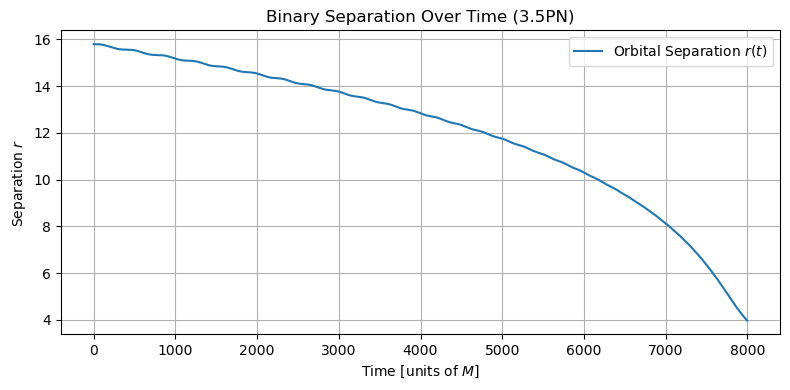

In [6]:
# r(t) is just the norm of the position vector (x, y)
r_vals_3PN = np.linalg.norm(results_3PN[:, 0:2], axis=1)

# Plot r(t)
plt.figure(figsize=(8, 4))
plt.plot(times_3PN, r_vals_3PN, label='Orbital Separation $r(t)$')
plt.xlabel('Time [units of $M$]')
plt.ylabel('Separation $r$')
plt.title(f'Binary Separation Over Time ({damping_order})')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Evolving dr/dt

In this model, we evolve directly the orbital separation $r(t)$, orbital frequency $\omega(t)$, and orbital phase $\phi(t)$ assuming a quasi-circular orbit.  
The system of equations is based on the 3.5PN accurate expressions for quasi-circular binaries, as presented in (2.7) and (2.8) Section II of Blanchet et al.,(https://arxiv.org/pdf/1204.1043).

$$
\frac{dr}{dt} = -\frac{64}{5} \sqrt{\frac{M}{r}} \nu \gamma^{5/2} \left( 1 + \gamma \left( -\frac{1751}{336} - \frac{7}{4} \nu \right) \right)
$$

$$
\frac{d\omega}{dt} = \frac{96}{5} \frac{M \nu}{r^3} \gamma^{5/2} \left( 1 + \gamma \left( -\frac{2591}{336} - \frac{11}{12} \nu \right) \right)
$$

$$
\frac{d\phi}{dt} = \omega
$$

where:
- $M = m_1 + m_2 $ is the total mass,
- $\nu = \frac{m_1 m_2}{M^2}$ is the symmetric mass ratio,
- $\gamma$ is the corrected post-Newtonian expansion parameter, expanded according to Eq. (2.6) of the paper:
$
\gamma = x \left( 1 + \gamma_{\text{PN corrections}} \right)
$ with $x = (G M \omega / c^3)^{2/3}$.

These corrections include logarithmic terms and higher-order contributions necessary to accurately model the inspiral at 3.5PN order. 

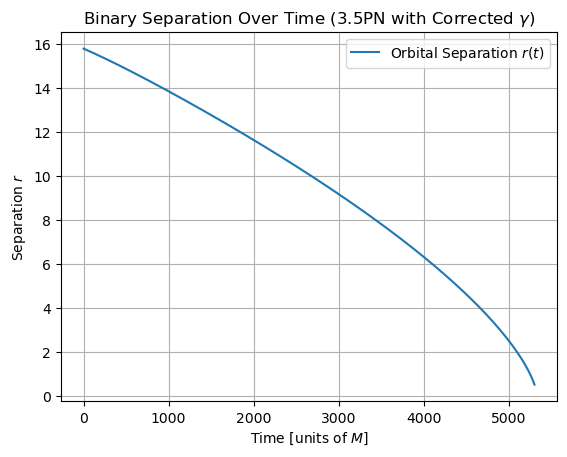

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants (in geometrized units)
G = 1.0
c = 1.0

# System Parameters
q = 1.5
m2 = 1.0
m1 = q * m2
m = m1 + m2
nu = m1 * m2 / m**2
r0 = 15.8

# Define the x parameter from orbital frequency omega
def x_from_omega(omega, m):
    return (G * m * omega / c**3)**(2/3)

# 3PN expression for gamma using equation (2.6)
def gamma_3pn(x, r, r0_prime=1.0):
    x2 = x**2
    x3 = x**3
    log_term = np.log(r / r0_prime)
    term1 = x * (1 - nu / 3)
    term2 = x2 * (1 - (65 / 12) * nu)
    term3 = x3 * (
        1 +
        (-2203 / 2520 - (41 * np.pi**2) / 192 - (22 / 3) * log_term) * nu +
        (229 / 36) * nu**2 + (nu**3 / 81)
    )
    return x * (1 + term1 + term2 + term3)

# 3PN Keplerian orbital frequency using corrected gamma
def omega_3pn(r, m, nu):
    omega_guess = np.sqrt(G * m / r**3)
    x = x_from_omega(omega_guess, m)
    gamma = gamma_3pn(x, r)
    return np.sqrt(G * m / r**3 * (
        1 + gamma * (-3 + nu) +
        gamma**2 * (6 + (41/4)*nu + nu**2) +
        gamma**3 * (-10 + (-75707/840 + (41 * np.pi**2)/64) * nu + (19/2)*nu**2 + nu**3)
    ))

# Radiation-Reaction Equations (3.5PN Averaged)
def drdt_35pn(r, m, nu, gamma):
    return - (64 / 5) * np.sqrt(m / r) * nu * gamma**(5/2) * (
        1 + gamma * (-1751/336 - (7/4)*nu)
    )

def domegadt_35pn(r, m, nu, gamma):
    return (96 / 5) * (m / r**3) * nu * gamma**(5/2) * (
        1 + gamma * (-2591/336 - (11/12)*nu)
    )

# System of ODEs
def orbit_averaged_dynamics(t, y, m, nu):
    r, omega, phi = y
    x = x_from_omega(omega, m)
    gamma = gamma_3pn(x, r)
    dr = drdt_35pn(r, m, nu, gamma)
    domega = domegadt_35pn(r, m, nu, gamma)
    dphi = omega
    return np.array([dr, domega, dphi])

# RK4 Integrator
def rk4_step(f, y, t, dt, *args):
    k1 = f(t, y, *args)
    k2 = f(t + dt/2, y + dt/2 * k1, *args)
    k3 = f(t + dt/2, y + dt/2 * k2, *args)
    k4 = f(t + dt, y + dt * k3, *args)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Initial Conditions
omega0 = omega_3pn(r0, m, nu)
phi0 = 0.0
y0 = np.array([r0, omega0, phi0])  # [r, omega, phi]

# Time Evolution
t = 0.0
dt = 0.1
T_final = 7000
y = y0.copy()

times_3PN_dr = []
results_3PN_dr = []

while t < T_final and y[0] > 0.5:
    times_3PN_dr.append(t)
    results_3PN_dr.append(y.copy())
    y = rk4_step(orbit_averaged_dynamics, y, t, dt, m, nu)
    t += dt

results_3PN_dr = np.array(results_3PN_dr)
times_3PN_dr = np.array(times_3PN_dr)

# Plotting
plt.plot(times_3PN_dr, results_3PN_dr[:, 0], label='Orbital Separation $r(t)$')
plt.xlabel('Time [units of $M$]')
plt.ylabel('Separation $r$')
plt.title('Binary Separation Over Time (3.5PN with Corrected $\\gamma$)')
plt.legend()
plt.grid()
plt.show()


# SURROGATE MODEL

### Extracting Data from the Surrogate Model NRSur7dq2

We use the NRSur7dq2 surrogate model to extract gravitational waveforms and orbital dynamics for a non-spinning binary system with mass ratio $q = 1.5$.  
The surrogate provides:
- The $(2,2)$ mode of the gravitational waveform $h_{22}$,
- The coorbital time array $t$,
- The orbital phase $\phi(t)$ and orbital frequency $\omega(t)$,
- The separation $r(t)$ inferred using the Kepler's law relation $r \sim \omega^{-2/3}$.


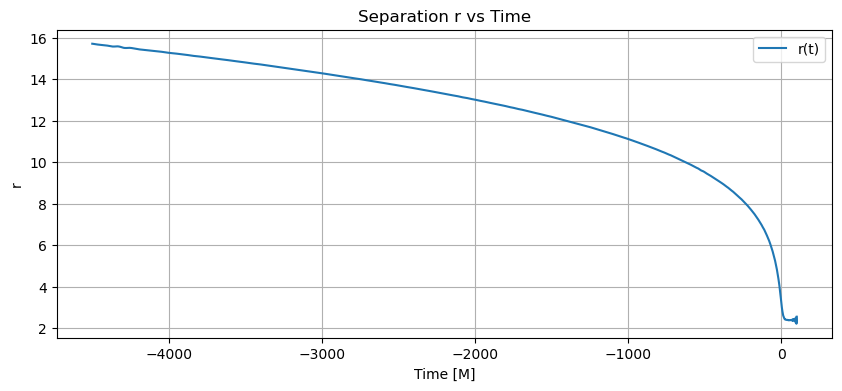

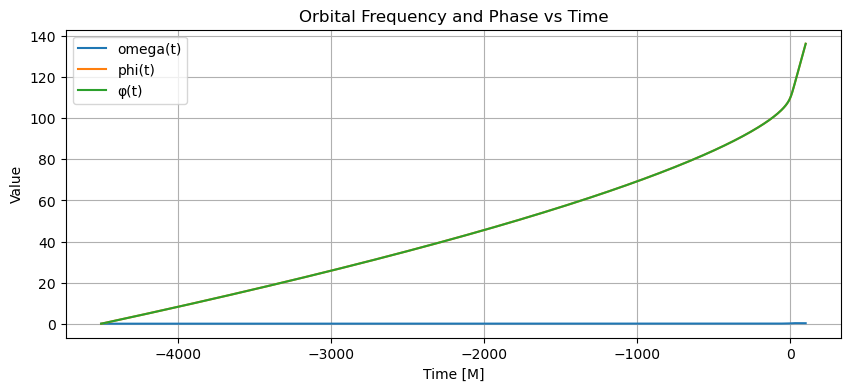

In [9]:
from NRSur7dq2 import NRSurrogate7dq2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sur = NRSurrogate7dq2()
q = 1.5  # Mass ratios
all_rows = []

chiA = np.array([0.0, 0.0, 0.0])
chiB = np.array([0.0, 0.0, 0.0])

modes, chiA_t, chiB_t = sur(q, chiA, chiB, return_spins=True)
quat, phi_orb, chiA_dyn, chiB_dyn = sur.get_dynamics(q, chiA, chiB)
quat = quat.T
tds = sur.tds

t = sur.t_coorb
h22 = modes[2, 2]

phi = -np.unwrap(np.angle(h22)) / 2.0
omega = np.gradient(phi, t)
r = (1.0 / (omega**2 + 1e-8))**(1 / 3)

omega_0 = omega[0]
r_0 = r[0]

for i in range(len(t)):
    row = {
        "time": t[i],
        "q": q,
        "r": r[i],
        "r_0": r_0,
        "omega": omega[i],
        "omega_0": omega_0,
        "h22_real": h22[i].real,
        "h22_imag": h22[i].imag,
        "phi": phi[i],
    }
    all_rows.append(row)

df_sur = pd.DataFrame(all_rows)

# --- Plot r(t) ---
plt.figure(figsize=(10, 4))
plt.plot(df_sur["time"], df_sur["r"], label="r(t)")
plt.title("Separation r vs Time")
plt.xlabel("Time [M]")
plt.ylabel("r")
plt.grid()
plt.legend()
plt.show()

# --- Plot w(t) and phi(t) ---
plt.figure(figsize=(10, 4))
plt.plot(df_sur["time"], df_sur["omega"], label="omega(t)")
plt.plot(df_sur["time"], df_sur["phi"], label="phi(t)")
plt.plot(tds, phi_orb, label='φ(t)')
plt.title("Orbital Frequency and Phase vs Time")
plt.xlabel("Time [M]")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

# plt.figure(figsize=(10, 4))
# plt.plot(df_sur["time"], df_sur["h22_real"], label="h+ ≈ Re(h22)")
# plt.plot(df_sur["time"], -df_sur["h22_imag"], label="hx ≈ -Im(h22)")
# plt.title("Gravitational Wave Polarisation")
# plt.xlabel("Time [M]")
# plt.ylabel("Strain")
# plt.grid()
# plt.legend()
# plt.show()


# PINN

We train a Physics-Informed Neural Network (PINN) to model the orbital dynamics and gravitational waveform of a non-spinning binary black hole system.  
The PINN learns from surrogate data while simultaneously respecting known physical relationships between the system’s variables.

The neural network takes as input:
- The coorbital time $t$,
- The mass ratio $q$,

and predicts:
- Orbital phase $\phi(t)$,
- Orbital separation $r(t)$,
- Orbital frequency $\omega(t)$,
- Real and imaginary parts of the $(2,2)$ gravitational waveform mode, $h_{22}(t)$.

Training the PINN involves minimising a composite loss function combining:
- **Supervised data loss** (mean squared error with surrogate data),
- **Physics-based constraints**, enforcing key dynamical relationships such as:
  - $\frac{d\phi}{dt} \approx \omega$ (phase evolution),
  - $r \approx \omega^{-2/3}$ (Kepler's law),
  - Consistent polarisations for $h_+$ and $h_\times$,
  - Correct initial conditions at $t = t_{\text{min}}$.

By embedding physical laws directly into the training process, the PINN achieves better generalisation and physical interpretability compared to purely data-driven models.

Epoch    0 | Train Loss: 9.6116e+00 | Val Loss: 9.8163e-01
Epoch  100 | Train Loss: 8.1648e-01 | Val Loss: 7.8624e-01
Epoch  200 | Train Loss: 7.4732e-01 | Val Loss: 7.2466e-01
Epoch  300 | Train Loss: 6.8179e-01 | Val Loss: 6.6395e-01
Epoch  400 | Train Loss: 6.4135e-01 | Val Loss: 6.2048e-01
Epoch  500 | Train Loss: 6.1646e-01 | Val Loss: 6.0125e-01
Epoch  600 | Train Loss: 6.0522e-01 | Val Loss: 5.9409e-01
Epoch  700 | Train Loss: 6.0139e-01 | Val Loss: 5.9020e-01
Epoch  800 | Train Loss: 5.9996e-01 | Val Loss: 5.8862e-01
Epoch  900 | Train Loss: 5.9900e-01 | Val Loss: 5.8840e-01


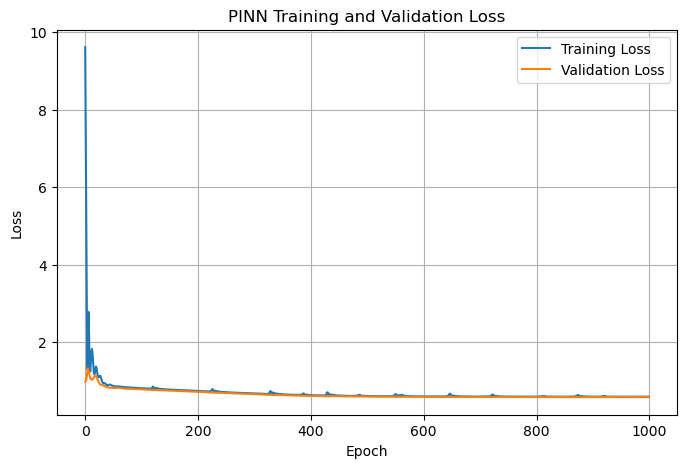

In [ ]:
# TRAINING PINN FOR BBH DYNAMICS (NO SPINS, WITH INITIAL CONDITIONS)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === 1. LOAD DATA ===
df = pd.read_csv("precessing_waveform_dataset3.csv")

# Inputs: time and q
X = df[['time', 'q']].values
Y = df[['phi', 'r', 'omega', 'h22_real', 'h22_imag']].values

# Normalise
gx = StandardScaler()
gy = StandardScaler()
X_scaled = gx.fit_transform(X)
Y_scaled = gy.fit_transform(Y)

# Split
torch.manual_seed(42)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# === 2. DEFINE MODEL ===
class PINN(nn.Module):
    def __init__(self, input_dim=2, output_dim=5, hidden=128, layers=5):
        super(PINN, self).__init__()
        layers_list = [nn.Linear(input_dim, hidden), nn.Tanh()]
        for _ in range(layers):
            layers_list += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers_list.append(nn.Linear(hidden, output_dim))
        self.net = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.net(x)

# === 3. DEFINE LOSSES ===

def finite_difference(y, t):
    # Computes finite difference derivative dy/dt
    dt = t[1:] - t[:-1]
    dy = y[1:] - y[:-1]
    dy_dt = dy / (dt + 1e-8)
    return torch.cat([dy_dt[:1], dy_dt], dim=0)  # Pad to match input size

def omega_phi_loss(phi_pred, omega_pred, t_input):
    # Enforces that dφ/dt ≈ ω (orbital frequency matches phase rate)
    dphi_dt = finite_difference(phi_pred, t_input)
    return torch.mean((dphi_dt - omega_pred) ** 2)

def r_omega_constraint_loss(r_pred, omega_pred):
    # Enforces that r ≈ ω^{-2/3} from Kepler's law
    r_expected = (1.0 / (omega_pred ** 2 + 1e-8)) ** (1/3)
    return torch.mean((r_pred - r_expected) ** 2)

def initial_condition_loss(model, X_scaled, Y_scaled):
    # Enforces that the model matches initial conditions at t = t_min
    model.eval()
    with torch.no_grad():
        t_min = torch.min(X_scaled[:, 0])
        mask = (X_scaled[:, 0] == t_min)
        X_t0 = X_scaled[mask]
        Y_t0 = Y_scaled[mask]
        pred_t0 = model(X_t0)
    return torch.mean((pred_t0 - Y_t0)**2)

def waveform_projection_loss(phi_pred, h_real_pred, h_imag_pred):
    # Enforces that waveform polarisations (h+, hx) match expected phase structure
    cos2phi = torch.cos(2 * phi_pred.squeeze())
    sin2phi = torch.sin(2 * phi_pred.squeeze())
    h_plus_target = cos2phi
    h_cross_target = -sin2phi
    return torch.mean((h_real_pred - h_plus_target)**2 + (h_imag_pred - h_cross_target)**2)

def fourier_loss(h_pred, h_true):
    # Matches the magnitude of the Fourier transforms of predicted and true waveforms
    h_pred_fft = torch.fft.fft(h_pred)
    h_true_fft = torch.fft.fft(h_true)
    h_pred_mag = torch.abs(h_pred_fft)
    h_true_mag = torch.abs(h_true_fft)
    return torch.mean((h_pred_mag - h_true_mag)**2)


# === 4. TRAINING ===
model = PINN(input_dim=2, output_dim=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 1000
# Weight for losses
lambda_omega = 0.1
lambda_romega = 0.1
lambda_ic = 0.1  
lambda_waveform = 10
lambda_fourier = 0

train_losses = []
val_losses = []


for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    pred = model(X_train)

    phi_pred = pred[:, 0:1]      # phi
    r_pred = pred[:, 1:2]        # r(t)
    omega_pred = pred[:, 2:3]    # omega(t)
    h22_pred = pred[:, 3:5]      # waveform

    t_input = X_train[:, 0].unsqueeze(1)

    loss_data = loss_fn(pred, Y_train)
    loss_omega = omega_phi_loss(phi_pred, omega_pred, t_input)
    loss_romega = r_omega_constraint_loss(r_pred, omega_pred)
    loss_ic = initial_condition_loss(model, X_train, Y_train)
    loss_waveform_proj = waveform_projection_loss(phi_pred, h22_pred[:, 0], h22_pred[:, 1])
    loss_fourier_plus = fourier_loss(Y_train[:, 3].squeeze(), h22_pred[:,0].squeeze())
    loss_fourier_cross = fourier_loss(Y_train[:, 4].squeeze(), h22_pred[:,1].squeeze())



    total_loss = (
        loss_data
        + lambda_waveform * loss_waveform_proj
        + lambda_fourier * (loss_fourier_plus + loss_fourier_cross)
        + lambda_omega * loss_omega
        + lambda_romega * loss_romega
        + lambda_ic * loss_ic
    )

    total_loss.backward()
    optimizer.step()
# Record losses
    train_losses.append(total_loss.item())

    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(model(X_test), Y_test)
        val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Train Loss: {total_loss.item():.4e} | Val Loss: {val_loss.item():.4e}")


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PINN Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



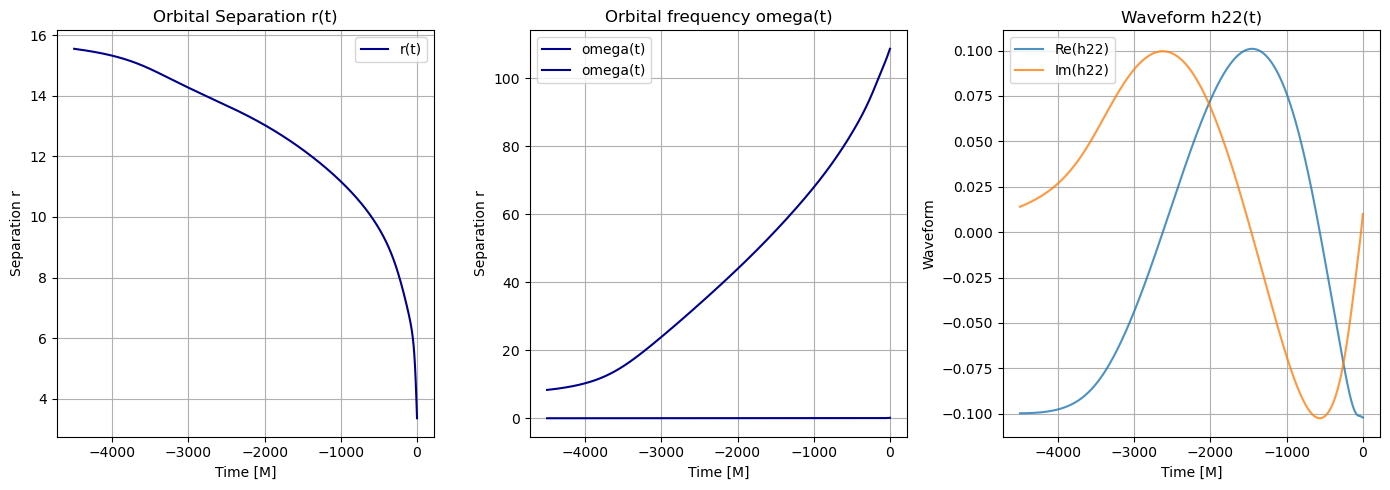

In [11]:
# Load trained model
model.eval()

# === Generate test input ===
q = 1.5
omega_0 = 0.02
t_vals_PINN = np.linspace(-4500, 0, 2000)

X_test = np.stack([
    t_vals_PINN,
    np.full_like(t_vals_PINN, q),
    # np.full_like(t_vals, omega_0)
], axis=1)

# === Scale inputs ===
X_scaled = gx.transform(X_test)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# === Predict ===
with torch.no_grad():
    Y_scaled = model(X_tensor)
Y_pred = gy.inverse_transform(Y_scaled.numpy())

phi_PINN, r_PINN, omega_PINN, h_real_PINN, h_imag_PINN = Y_pred.T
h22_PINN = h_real_PINN + 1j * h_imag_PINN

# === Plot results ===
plt.figure(figsize=(14, 5))

# --- Plot r(t) ---
plt.subplot(1, 3, 1)
plt.plot(t_vals_PINN, r_PINN, label='r(t)', color='darkblue')
plt.xlabel('Time [M]')
plt.ylabel('Separation r')
plt.title('Orbital Separation r(t)')
plt.grid(True)
plt.legend()

# --- Plot omega(t) and phi(t) ---
plt.subplot(1, 3, 2)
plt.plot(t_vals_PINN, omega_PINN, label='omega(t)', color='darkblue')
plt.plot(t_vals_PINN, phi_PINN, label='omega(t)', color='darkblue')
plt.xlabel('Time [M]')
plt.ylabel('Separation r')
plt.title('Orbital frequency omega(t)')
plt.grid(True)
plt.legend()

# --- Plot waveform h22 ---
plt.subplot(1, 3, 3)
plt.plot(t_vals_PINN, h_real_PINN, label='Re(h22)', alpha=0.8)
plt.plot(t_vals_PINN, h_imag_PINN, label='Im(h22)', alpha=0.8)
plt.xlabel('Time [M]')
plt.ylabel('Waveform')

plt.title('Waveform h22(t)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Compare results

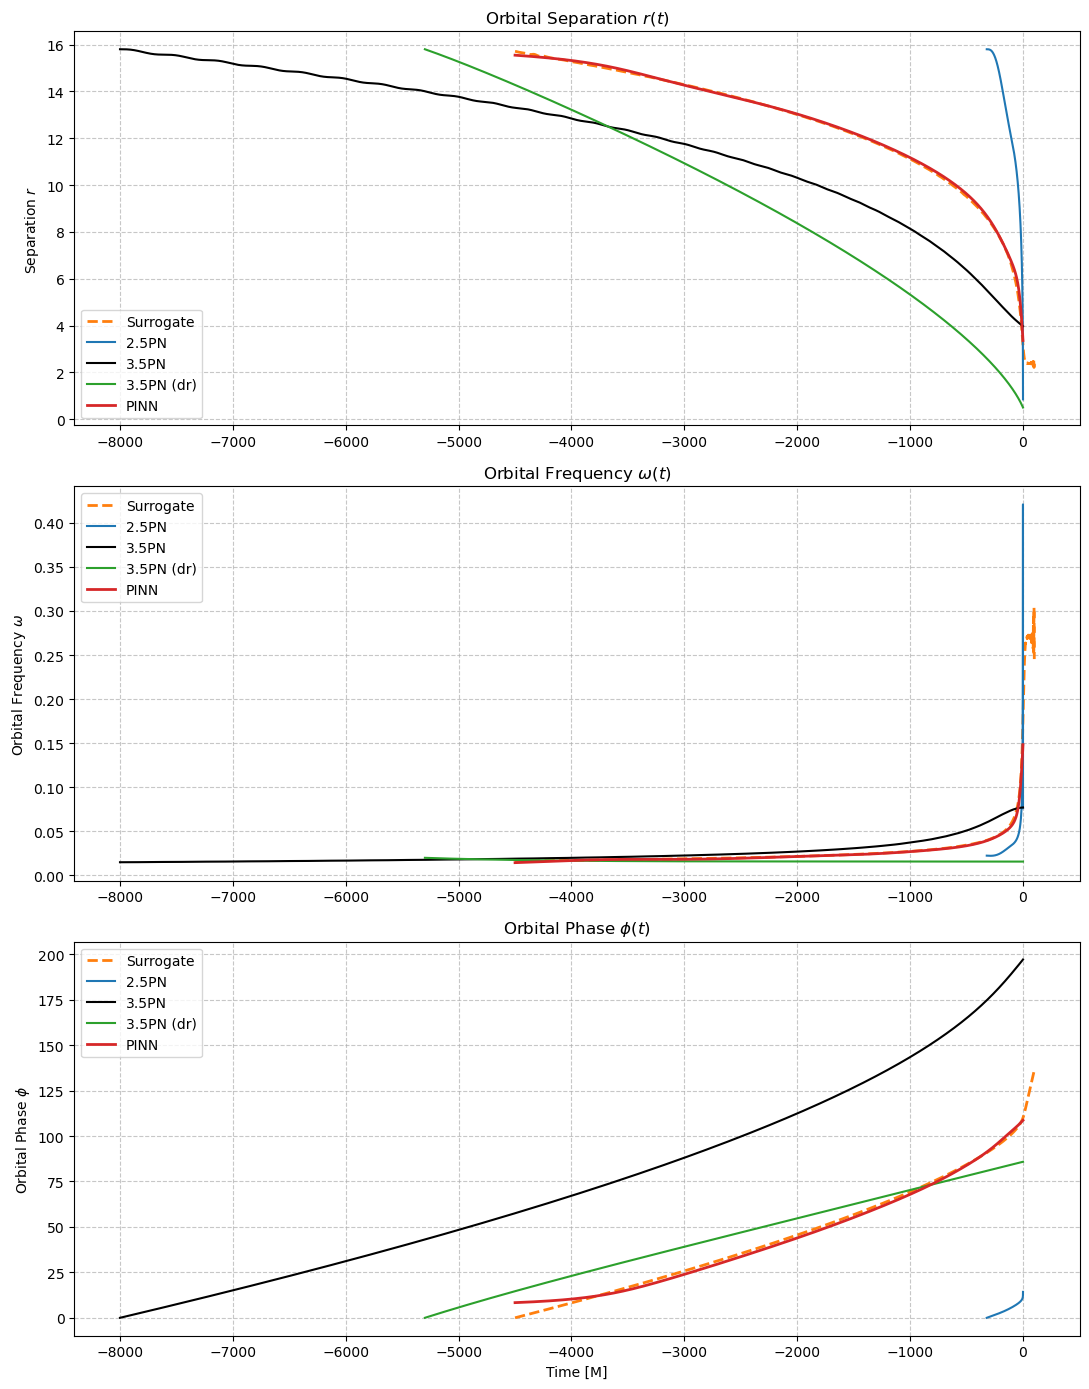

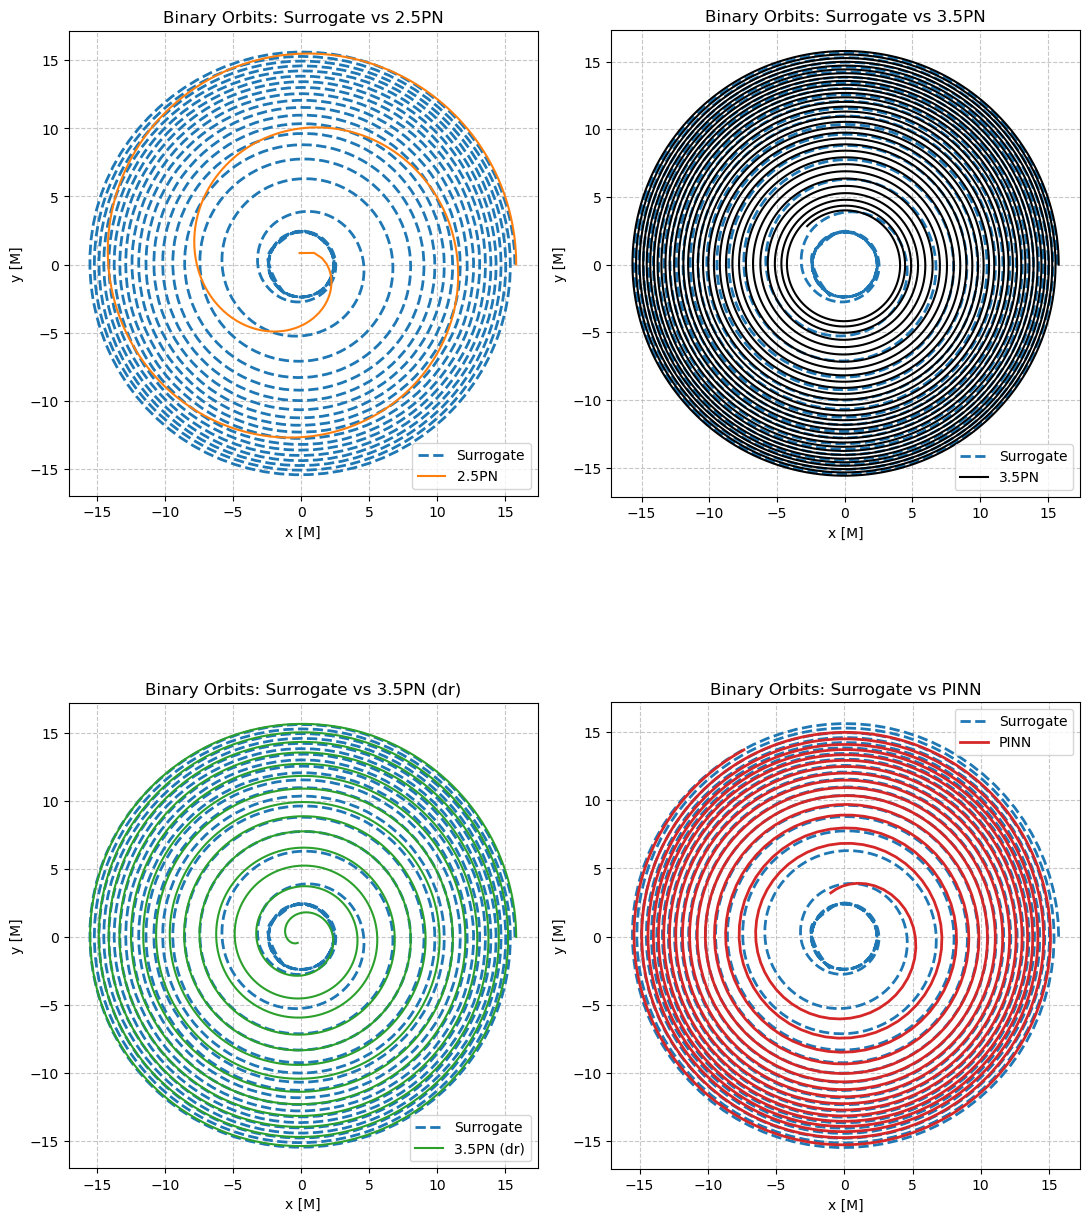

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ==============================
# === 1. PREPARE THE MODELS ===
# ==============================

# === Surrogate ===
t_coorb = df_sur["time"].values
r_sur = df_sur["r"].values
omega_sur = df_sur["omega"].values
phi_sur = df_sur["phi"].values

# === 2.5PN ===
times_2PN = np.array(times_2PN)
t_end_2PN = times_2PN[-1]
times_2PN = times_2PN - t_end_2PN
r_2PN = np.linalg.norm(results_2PN[:, 0:2], axis=1)
phi_2PN = results_2PN[:, 4]
omega_2PN = (results_2PN[:, 0] * results_2PN[:, 3] - results_2PN[:, 1] * results_2PN[:, 2]) / (r_2PN**2)

# === 3.5PN ===
times_3PN_dr = np.array(times_3PN_dr)
t_end_3PN_dr = times_3PN_dr[-1]
times_3PN_dr = times_3PN_dr - t_end_3PN_dr
r_3PN_dr = results_3PN_dr[:, 0]
omega_3PN_dr = results_3PN_dr[:, 1]
phi_3PN_dr = results_3PN_dr[:, 2]

# === 3PN ===
times_3PN = np.array(times_3PN)
t_end_3PN = times_3PN[-1]
times_3PN = times_3PN - t_end_3PN
r_3PN = np.linalg.norm(results_3PN[:, 0:2], axis=1)
phi_3PN = results_3PN[:, 4]
omega_3PN = (results_3PN[:, 0] * results_3PN[:, 3] - results_3PN[:, 1] * results_3PN[:, 2]) / (r_3PN**2)

# === PINN ===
t_vals_PINN = np.linspace(-4500, 0, 2000)

# ==============================
# === 2. PLOTTING ===
# ==============================

fig, axs = plt.subplots(3, 1, figsize=(11, 14), sharex=False)

# --- Separation r(t) ---
axs[0].plot(t_coorb, r_sur, linestyle='--', linewidth=2, color='tab:orange', label='Surrogate')
axs[0].plot(times_2PN, r_2PN, linestyle='-', linewidth=1.5, color='tab:blue', label='2.5PN')
axs[0].plot(times_3PN, r_3PN, linestyle='-', linewidth=1.5, color='black', label='3.5PN')
axs[0].plot(times_3PN_dr, r_3PN_dr, linestyle='-', linewidth=1.5, color='tab:green', label='3.5PN (dr)')
axs[0].plot(t_vals_PINN, r_PINN, linestyle='-', linewidth=2, color='tab:red', label='PINN')
axs[0].set_ylabel('Separation $r$')
axs[0].set_title('Orbital Separation $r(t)$')
axs[0].grid(True, which='both', linestyle='--', alpha=0.7)
axs[0].legend()

# --- Orbital Frequency omega(t) ---
axs[1].plot(t_coorb, omega_sur, linestyle='--', linewidth=2, color='tab:orange', label='Surrogate')
axs[1].plot(times_2PN, omega_2PN, linestyle='-', linewidth=1.5, color='tab:blue', label='2.5PN')
axs[1].plot(times_3PN, omega_3PN, linestyle='-', linewidth=1.5, color='black', label='3.5PN')
axs[1].plot(times_3PN_dr, omega_3PN_dr, linestyle='-', linewidth=1.5, color='tab:green', label='3.5PN (dr)')
axs[1].plot(t_vals_PINN, omega_PINN, linestyle='-', linewidth=2, color='tab:red', label='PINN')
axs[1].set_ylabel('Orbital Frequency $\\omega$')
axs[1].set_title('Orbital Frequency $\\omega(t)$')
axs[1].grid(True, which='both', linestyle='--', alpha=0.7)
axs[1].legend()

# --- Orbital Phase phi(t) ---
axs[2].plot(t_coorb, phi_sur, linestyle='--', linewidth=2, color='tab:orange', label='Surrogate')
axs[2].plot(times_2PN, phi_2PN, linestyle='-', linewidth=1.5, color='tab:blue', label='2.5PN')
axs[2].plot(times_3PN, phi_3PN, linestyle='-', linewidth=1.5, color='black', label='3.5PN')
axs[2].plot(times_3PN_dr, phi_3PN_dr, linestyle='-', linewidth=1.5, color='tab:green', label='3.5PN (dr)')
axs[2].plot(t_vals_PINN, phi_PINN, linestyle='-', linewidth=2, color='tab:red', label='PINN')
axs[2].set_ylabel('Orbital Phase $\\phi$')
axs[2].set_xlabel('Time [M]')
axs[2].set_title('Orbital Phase $\\phi(t)$')
axs[2].grid(True, which='both', linestyle='--', alpha=0.7)
axs[2].legend()

plt.tight_layout()
plt.show()

# ==============================
# === 3. ORBIT PLOT (STATIC) ===
# ==============================

# --- Compute x(t) and y(t) for each model ---

# Surrogate
x_sur = r_sur * np.cos(phi_sur)
y_sur = r_sur * np.sin(phi_sur)

# 2.5PN
x_2PN = r_2PN * np.cos(phi_2PN)
y_2PN = r_2PN * np.sin(phi_2PN)

# 3PN
x_3PN = r_3PN * np.cos(phi_3PN)
y_3PN = r_3PN * np.sin(phi_3PN)

# 3.5PN
x_3PN_dr = r_3PN_dr * np.cos(phi_3PN_dr)
y_3PN_dr = r_3PN_dr * np.sin(phi_3PN_dr)

# PINN
x_PINN = r_PINN * np.cos(phi_PINN)
y_PINN = r_PINN * np.sin(phi_PINN)

# --- Plot all orbits together ---

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(11, 14), sharex=False)

# First subplot
axs[0, 0].plot(x_sur, y_sur, '--', label='Surrogate', linewidth=2)
axs[0, 0].plot(x_2PN, y_2PN, '-', label='2.5PN', linewidth=1.5)
axs[0, 0].set_xlabel('x [M]')
axs[0, 0].set_ylabel('y [M]')
axs[0, 0].set_title('Binary Orbits: Surrogate vs 2.5PN')
axs[0, 0].grid(True, which='both', linestyle='--', alpha=0.7)
axs[0, 0].legend()
axs[0, 0].set_aspect('equal')

# Second subplot
axs[0, 1].plot(x_sur, y_sur, '--', label='Surrogate', linewidth=2)
axs[0, 1].plot(x_3PN, y_3PN, '-', label='3.5PN', color='black', linewidth=1.5)
axs[0, 1].set_xlabel('x [M]')
axs[0, 1].set_ylabel('y [M]')
axs[0, 1].set_title('Binary Orbits: Surrogate vs 3.5PN')
axs[0, 1].grid(True, which='both', linestyle='--', alpha=0.7)
axs[0, 1].legend()
axs[0, 1].set_aspect('equal')

# Third subplot
axs[1, 0].plot(x_sur, y_sur, '--', label='Surrogate', linewidth=2)
axs[1, 0].plot(x_3PN_dr, y_3PN_dr, '-', label='3.5PN (dr)', color='tab:green', linewidth=1.5)
axs[1, 0].set_xlabel('x [M]')
axs[1, 0].set_ylabel('y [M]')
axs[1, 0].set_title('Binary Orbits: Surrogate vs 3.5PN (dr)')
axs[1, 0].grid(True, which='both', linestyle='--', alpha=0.7)
axs[1, 0].legend()
axs[1, 0].set_aspect('equal')

# Fourth subplot
axs[1, 1].plot(x_sur, y_sur, '--', label='Surrogate', linewidth=2)
axs[1, 1].plot(x_PINN, y_PINN, '-', label='PINN', color='tab:red', linewidth=2)
axs[1, 1].set_xlabel('x [M]')
axs[1, 1].set_ylabel('y [M]')
axs[1, 1].set_title('Binary Orbits: Surrogate vs PINN')
axs[1, 1].grid(True, which='both', linestyle='--', alpha=0.7)
axs[1, 1].legend()
axs[1, 1].set_aspect('equal')

plt.tight_layout()
plt.show()


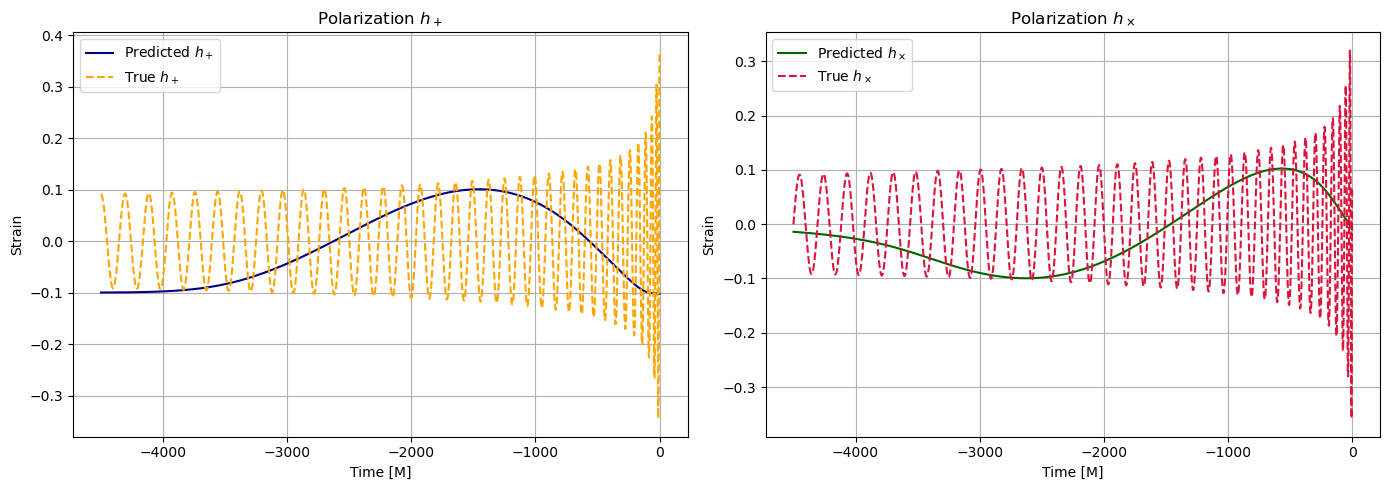

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

# Ensure the model is in evaluation mode
model.eval()

# === 1. Generate test input ===
q = 1.5
t_vals = np.linspace(-4500, 0, 2000)

X_test = np.stack([
    t_vals,
    np.full_like(t_vals, q),
], axis=1)

# === 2. Scale input and predict ===
X_scaled = gx.transform(X_test)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

with torch.no_grad():
    Y_scaled = model(X_tensor)

Y_pred = gy.inverse_transform(Y_scaled.numpy())
phi, r, omega, h_real, h_imag = Y_pred.T

# Compute h+ and h× from the real and imaginary parts
hplus_pred = h_real
hcross_pred = -h_imag

# === 3. Load ground-truth data for comparison ===
df_true = pd.read_csv("precessing_waveform_dataset3.csv")
df_q = df_true[df_true['q'] == q].copy()
df_q = df_q[(df_q['time'] >= t_vals.min()) & (df_q['time'] <= t_vals.max())]
df_q = df_q.sort_values(by='time')

# === 4. Interpolate ground truth to align with t_vals ===
interp_hplus = interp1d(df_q['time'], df_q['h22_real'], kind='cubic', fill_value="extrapolate")
interp_hcross = interp1d(df_q['time'], -df_q['h22_imag'], kind='cubic', fill_value="extrapolate")

hplus_true = interp_hplus(t_vals)
hcross_true = interp_hcross(t_vals)

# === 5. Plot comparison ===
plt.figure(figsize=(14, 5))

# h+ polarisation
plt.subplot(1, 2, 1)
plt.plot(t_vals, hplus_pred, label='Predicted $h_+$', color='navy')
plt.plot(t_vals, hplus_true, '--', label='True $h_+$', color='orange')
plt.xlabel('Time [M]')
plt.ylabel('Strain')
plt.title('Polarization $h_+$')
plt.grid(True)
plt.legend()

# h× polarisation
plt.subplot(1, 2, 2)
plt.plot(t_vals, hcross_pred, label='Predicted $h_\\times$', color='darkgreen')
plt.plot(t_vals, hcross_true, '--', label='True $h_\\times$', color='crimson')
plt.xlabel('Time [M]')
plt.ylabel('Strain')
plt.title('Polarization $h_\\times$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

